# Training a GAP model

## steps
    1. generate a small dataset of water structures 
        - use CP2K if you havea access to it
        - otherwise: use any simple potential implemented in ASE, just for trying this out I have used EMT here
    1. generate e0 values
    1. separate a training and a validation dataset
    1. **train the model**
    1. look at the outcome of the model
    

## here we will fit twice, to see the difference between a 2b-only and a 2b+3b fit

In [1]:
# general imports 
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp

# ase imports
import ase.io
from ase.visualize import view
from ase import Atoms, Atom
from ase import units
from ase.build import molecule
# for MD
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory

In [2]:
# helper functions
def make_water(density, super_cell=[3, 3, 3]):
    """ Geenrates a supercell of water molecules with a desired density.
        Density in g/cm^3!!!"""
    h2o = molecule('H2O')
    a = np.cbrt((sum(h2o.get_masses()) * units.m ** 3 * 1E-6 ) / (density * units.mol))
    h2o.set_cell((a, a, a))
    h2o.set_pbc((True, True, True))
    #return cp(h2o.repeat(super_cell))
    return h2o.repeat(super_cell)

def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

## generating data only with ASE, using the EMT calculator

This is only for the demonstration of how to do it, this run is will be done very fast. There is no practical use of the data beyond lerning the use teach_sparse, quip, etc. with it.

In [3]:
# Running MD with ASE's EMT

from ase.calculators.emt import EMT
calc = EMT()

T = 150  # Kelvin

# Set up a grid of water
water = make_water(1.0, [3, 3, 3])
water.set_calculator(calc)

# We want to run MD using the Langevin algorithm
# with a time step of 1 fs, the temperature T and the friction
# coefficient to 0.002 atomic units.
dyn = Langevin(water, 1 * units.fs, T * units.kB, 0.0002)

def printenergy(a=water):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

dyn.attach(printenergy, interval=5)

# We also want to save the positions of all atoms after every 5th time step.
traj = Trajectory('dyn_emt.traj', 'w', water)
dyn.attach(traj.write, interval=5)

# Now run the dynamics
printenergy(water)
dyn.run(600)   # CHANGE THIS IF YOU WANT LONGER/SHORTER RUN

Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.820eV  Ekin = 0.053eV (T=413K)  Etot = 0.874eV
Energy per atom: Epot = 0.660eV  Ekin = 0.208eV (T=1610K)  Etot = 0.868eV
Energy per atom: Epot = 0.632eV  Ekin = 0.224eV (T=1734K)  Etot = 0.857eV
Energy per atom: Epot = 0.869eV  Ekin = 0.005eV (T= 39K)  Etot = 0.874eV
Energy per atom: Epot = 0.780eV  Ekin = 0.089eV (T=688K)  Etot = 0.869eV
Energy per atom: Epot = 0.756eV  Ekin = 0.117eV (T=908K)  Etot = 0.873eV
Energy per atom: Epot = 0.707eV  Ekin = 0.164eV (T=1270K)  Etot = 0.871eV
Energy per atom: Epot = 0.703eV  Ekin = 0.158eV (T=1225K)  Etot = 0.862eV
Energy per atom: Epot = 0.868eV  Ekin = 0.006eV (T= 50K)  Etot = 0.874eV
Energy per atom: Epot = 0.704eV  Ekin = 0.160eV (T=1242K)  Etot = 0.865eV
Energy per atom: Epot = 0.678eV  Ekin = 0.191eV (T=1476K)  Etot = 0.869eV
Energy per atom: Epot = 0.826eV  Ekin = 0.047

Energy per atom: Epot = 0.381eV  Ekin = 0.555eV (T=4292K)  Etot = 0.936eV
Energy per atom: Epot = 0.389eV  Ekin = 0.547eV (T=4231K)  Etot = 0.936eV
Energy per atom: Epot = 0.403eV  Ekin = 0.535eV (T=4140K)  Etot = 0.938eV
Energy per atom: Epot = 0.434eV  Ekin = 0.507eV (T=3925K)  Etot = 0.941eV
Energy per atom: Epot = 0.420eV  Ekin = 0.519eV (T=4019K)  Etot = 0.940eV
Energy per atom: Epot = 0.414eV  Ekin = 0.530eV (T=4104K)  Etot = 0.945eV
Energy per atom: Epot = 0.457eV  Ekin = 0.491eV (T=3799K)  Etot = 0.948eV
Energy per atom: Epot = 0.453eV  Ekin = 0.494eV (T=3821K)  Etot = 0.947eV
Energy per atom: Epot = 0.439eV  Ekin = 0.506eV (T=3913K)  Etot = 0.945eV
Energy per atom: Epot = 0.463eV  Ekin = 0.488eV (T=3774K)  Etot = 0.950eV
Energy per atom: Epot = 0.434eV  Ekin = 0.522eV (T=4042K)  Etot = 0.957eV


True

In [17]:
view(out_traj)

In [13]:
# wrap and save traj in .xyz --- the .traj is a non human readable database file, xyz is much better
out_traj = ase.io.read('dyn_emt.traj', ':')
for at in out_traj:
    at.wrap()
    if 'momenta' in at.arrays: del at.arrays['momenta']
ase.io.write('dyn_emt.xyz', out_traj, 'xyz')

## get e0 for H and O - energies of the isolated atoms

This is the energy of the isolated atom, will be in the teach_sparse string in the following format: `e0={H:energy:O:energy}`

In [6]:
isolated_H = Atoms('H', calculator=EMT(), cell=[20, 20, 20], pbc=True)
isolated_O = Atoms('O', calculator=EMT(), cell=[20, 20, 20], pbc=True)

print('e0_H:',isolated_H.get_potential_energy())
print('e0_O:',isolated_O.get_potential_energy())

# this made the e0 string be the following: e0={H:3.21:O:4.6}

e0_H: 3.21
e0_O: 4.6


## separate the dataset into a training and a validation set

As we have 120 frames from the 600fs MD, I will do it 60,60 with taking even and odd frames for the two

In [7]:
ase.io.write('train.xyz', out_traj[0::2] + [isolated_H] + [isolated_O])  
ase.io.write('validate.xyz', out_traj[1::2])

In [8]:
out_traj[0].arrays.keys()

dict_keys(['numbers', 'positions'])

## train our GAP model from the command line

Will use a fit of 2b only, using the desciptor distance_2b.

Let's understand how this works. The bash command takes named arguments separated by spaces.

- `gap_fit` the command which actually does the fit (updated here from published tutorial to current command)
- `e0={H:3.21:O:4.6}` the energies of the isolated atoms
- `energy_parameter_name=energy force_parameter_name=forces` names of the parameters
- `do_copy_at_file=F sparse_separate_file=T` just needed, don't want to copy the training data and using separate files for the xml makes it faster
- `gp_file=GAP.xml` filename of the potential parameters, I have always used this name, because I had separate directories for the different trainings potentials
- `at_file=train.xyz` training file
- `default_sigma={0.008 0.04 0 0}` sigma values to be used for energies, forces, stresses, hessians in order; this represents the accuracy of the data and the relative weight of them in the fit (more accurate --> more significant in the fit)
- `gap={...}` the potential to be fit, separated by ':'

**distance_2b**
- `cutoff=4.0` radial, practically the highest distance the descriptor takes into account 
- `covariance_type=ard_se` use gausses in the fit
- `delta=0.5` what relative portion of the things shall be determined by this potential
- `theta_uniform=1.0` width of the gaussians
- `sparse_method=uniform` use uniform bins to choose the sparse points
- `add_species=T ` take the species into account, so it will generate more GAPs automatically (see the output)
- `n_sparse=10` number of sparse points


## notice, that the script is running in parallel, using all 8 cores of the current machine

In [12]:
! ~/miniconda3/lib/python3.7/site-packages/quippy/gap_fit \
energy_parameter_name=energy \
force_parameter_name=forces \
do_copy_at_file=F \
sparse_separate_file=T \
gp_file=GAP.xml at_file=train.xyz \
default_sigma={0.008 0.04 0 0} \
gap={distance_2b cutoff=4.0 covariance_type=ard_se delta=0.5 \
     theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10}


libAtoms::Hello World: 03/05/2020   20:55:12
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,fd5d621cb-dirty
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran
libAtoms::Hello World: compiled on  Apr 27 2020 at 23:41:07
libAtoms::Hello World: Random Seed = 75312474
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

atoms_filename = //MANDATORY//
at_file = train.xyz
gap = "distance_2b cutoff=4.0 covariance_type=ard_se delta=0.5 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10"
e0 = 0.0
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_kernel_regularisation = //MANDATORY//
default_sigma = "0.008 0.04 0 0"
sparse_jitter = 1.0e-10
hessian_displacement = 1.0e-2
hessian_delta = 1.0e-2
baseline_param_filename = quip_params.xml
core_param_file = quip_params.xml
baseline_ip_args =
core_ip_args =
energy_pa


Finished sparse covariance matrix calculation of coordinate 2
TIMER: gpFull_covarianceMatrix_sparse_Coordinate2_sparse  done in .12426199999999998 cpu secs, .12425989300027140 wall clock secs.
TIMER: gpFull_covarianceMatrix_sparse_Coordinate2         done in .12428400000000001 cpu secs, .12428178199843387 wall clock secs.
Started sparse covariance matrix calculation of coordinate 3

Finished sparse covariance matrix calculation of coordinate 3
TIMER: gpFull_covarianceMatrix_sparse_Coordinate3_sparse  done in .12909700000000002 cpu secs, .12909523900088971 wall clock secs.
TIMER: gpFull_covarianceMatrix_sparse_Coordinate3         done in .12912200000000001 cpu secs, .12911969200285967 wall clock secs.
TIMER: gpFull_covarianceMatrix_sparse_LinearAlgebra       done in .19112999999999936E-001 cpu secs, .19115004000923363E-001 wall clock secs.
TIMER: gpFull_covarianceMatrix_sparse_FunctionValues      done in .21999999999966491E-004 cpu secs, .22297997929854318E-004 wall clock secs.
TIMER: 

## use the potential with QUIP on trani.xyz and validate.xyz

In [4]:
# calculate train.xyz

! ~/miniconda3/lib/python3.7/site-packages/quippy/quip E=T F=T atoms_filename=train.xyz param_filename=GAP.xml | grep AT | sed 's/AT//' > quip_train.xyz
! ~/miniconda3/lib/python3.7/site-packages/quippy/quip E=T F=T atoms_filename=validate.xyz param_filename=GAP.xml | grep AT | sed 's/AT//' > quip_validate.xyz

## make simple plots of the energies and forces on the EMT and GAP datas

In [5]:
def energy_plot(in_file, out_file, ax, title='Plot of energy'):
    """ Plots the distribution of energy per atom on the output vs the input"""
    # read files
    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')
    # list energies
    ener_in = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in in_atoms]
    ener_out = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in out_atoms]
    # scatter plot of the data
    ax.scatter(ener_in, ener_out)
    # get the appropriate limits for the plot
    for_limits = np.array(ener_in +ener_out)   
    elim = (for_limits.min() - 0.05, for_limits.max() + 0.05)
    ax.set_xlim(elim)
    ax.set_ylim(elim)
    # add line of slope 1 for refrence
    ax.plot(elim, elim, c='k')
    # set labels
    ax.set_ylabel('energy by GAP / eV')
    ax.set_xlabel('energy by EMT / eV')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(ener_in, ener_out)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/atom'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right', 
            verticalalignment='bottom')
    
def force_plot(in_file, out_file, ax, symbol='HO', title='Plot of force'):
    """ Plots the distribution of firce components per atom on the output vs the input 
        only plots for the given atom type(s)"""
    
    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')
    
    # extract data for only one species
    in_force, out_force = [], []
    for at_in, at_out in zip(in_atoms, out_atoms):
        # get the symbols
        sym_all = at_in.get_chemical_symbols()
        # add force for each atom
        for j, sym in enumerate(sym_all):
            if sym in symbol:
                in_force.append(at_in.get_forces()[j])
                #out_force.append(at_out.get_forces()[j]) \  
                out_force.append(at_out.arrays['force'][j]) # because QUIP and ASE use different names
    # convert to np arrays, much easier to work with
    #in_force = np.array(in_force)
    #out_force = np.array(out_force)
    # scatter plot of the data
    ax.scatter(in_force, out_force)
    # get the appropriate limits for the plot
    for_limits = np.array(in_force + out_force)   
    flim = (for_limits.min() - 1, for_limits.max() + 1)
    ax.set_xlim(flim)
    ax.set_ylim(flim)
    # add line of 
    ax.plot(flim, flim, c='k')
    # set labels
    ax.set_ylabel('force by GAP / (eV/Å)')
    ax.set_xlabel('force by EMT / (eV/Å)')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(in_force, out_force)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/Å'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right', 
            verticalalignment='bottom')

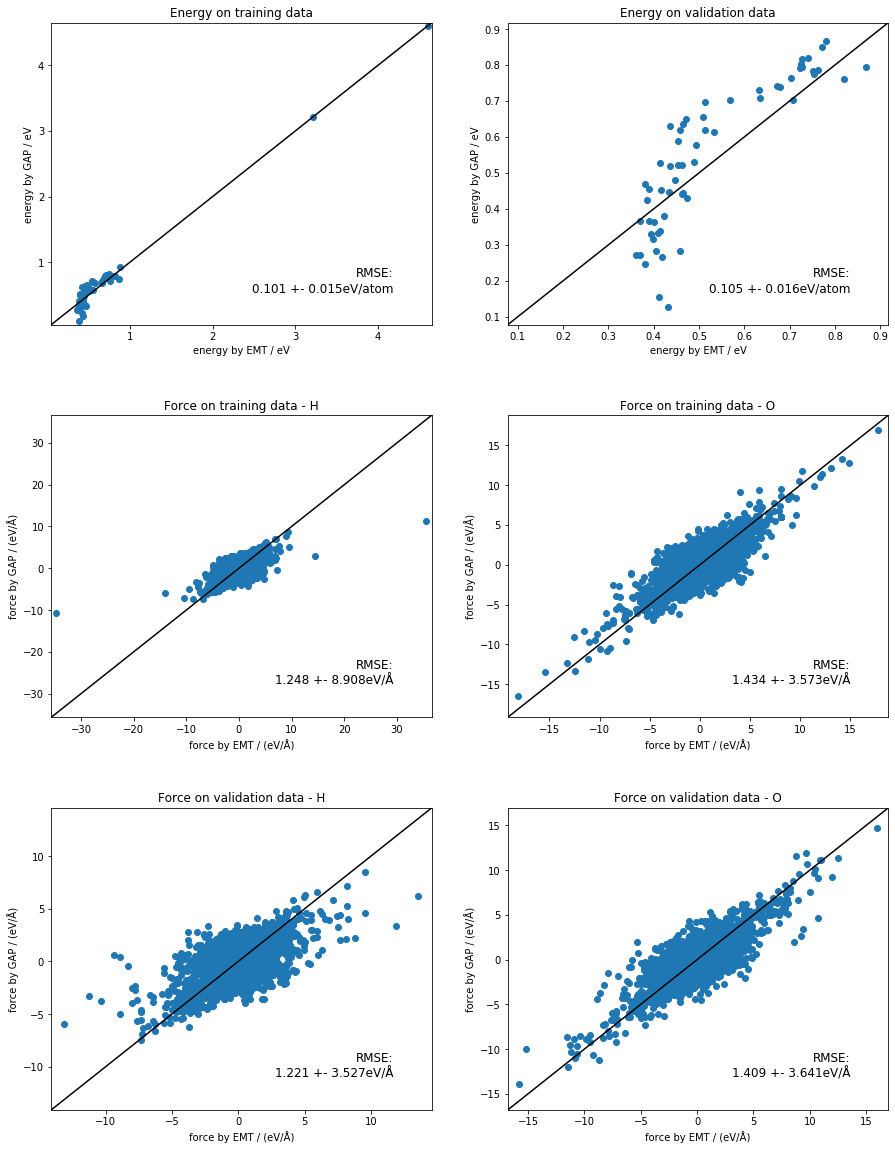

In [6]:
fig, ax_list = plt.subplots(nrows=3, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]

energy_plot('train.xyz', 'quip_train.xyz', ax_list[0], 'Energy on training data')
energy_plot('validate.xyz', 'quip_validate.xyz', ax_list[1], 'Energy on validation data')
force_plot('train.xyz', 'quip_train.xyz', ax_list[2], 'H', 'Force on training data - H')
force_plot('train.xyz', 'quip_train.xyz', ax_list[3], 'O', 'Force on training data - O')
force_plot('validate.xyz', 'quip_validate.xyz', ax_list[4], 'H', 'Force on validation data - H')
force_plot('validate.xyz', 'quip_validate.xyz', ax_list[5], 'O',  'Force on validation data - O')

# if you wanted to have the same limits on the force plots
#for ax in ax_list[2:]:
#    flim = (-20, 20)
#    ax.set_xlim(flim)
#    ax.set_ylim(flim)

## train our GAP_3b model from the command line

Let's add three ody terms to the fit, which will hopefully improve it. We will be using the desciprtors distance_2b and angle_3b.

**angle_3b**
- `theta_fac=0.5` this takes the input data and determines the width from that; useful here, because the dimensions of the descriptor are different
- `n_sparse=50` higher dimensional space, more sparse points

## both training and quip takes significantly more time than the last one!!!

In [7]:
! ~/miniconda3/lib/python3.7/site-packages/quippy/gap_fit energy_parameter_name=energy force_parameter_name=forces do_copy_at_file=F sparse_separate_file=T gp_file=GAP_3b.xml at_file=train.xyz default_sigma={0.008 0.04 0 0} gap={distance_2b cutoff=4.0 covariance_type=ard_se delta=0.5 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10 : angle_3b cutoff=3.5 covariance_type=ard_se delta=0.5 theta_fac=0.5 add_species=T n_sparse=30 sparse_method=uniform}


libAtoms::Hello World: 04/05/2020   00:27:10
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,fd5d621cb-dirty
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran
libAtoms::Hello World: compiled on  Apr 27 2020 at 23:41:07
libAtoms::Hello World: Random Seed = 1630919
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

atoms_filename = //MANDATORY//
at_file = train.xyz
gap = "distance_2b cutoff=4.0 covariance_type=ard_se delta=0.5 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10 : angle_3b cutoff=3.5 covariance_type=ard_se delta=0.5 theta_fac=0.5 add_species=T n_sparse=30 sparse_method=uniform"
e0 = 0.0
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_kernel_regularisation = //MANDATORY//
default_sigma = "0.008 0.04 0 0"
sparse_jitter = 1.0e-10
hessian_displacement = 1.0e-2
hessian_delta = 1.0e-2
bas


========== Report on number of target properties found in training XYZ: ========

Number of target energies (property name: energy) found: 63
Number of target local_properties (property name: local_property) found: 0
Number of target forces (property name: forces) found: 14829
Number of target virials (property name: virial) found: 0
Number of target Hessian eigenvalues (property name: hessian) found: 0

================================= End of report ================================


===== Report on per-configuration/per-atom sigma (error parameter) settings ====

Number of per-configuration setting of energy_sigma found:     0
Number of per-configuration setting of force_sigma found:      0
Number of per-configuration setting of virial_sigma found:     0
Number of per-configuration setting of hessian_sigma found:    0
Number of per-atom setting of force_atom_sigma found:          0
Number of per-component setting of force_component_sigma found:          0

=========================

## use the potential with QUIP on trani.xyz and validate.xyz

In [10]:
# calculate train.xyz

! ~/miniconda3/lib/python3.7/site-packages/quippy/quip E=T F=T atoms_filename=train.xyz param_filename=GAP_3b.xml | grep AT | sed 's/AT//' > quip_3b_train.xyz
! ~/miniconda3/lib/python3.7/site-packages/quippy/quip E=T F=T atoms_filename=validate.xyz param_filename=GAP_3b.xml | grep AT | sed 's/AT//' > quip_3b_validate.xyz

## look at the outputs - clear improvement

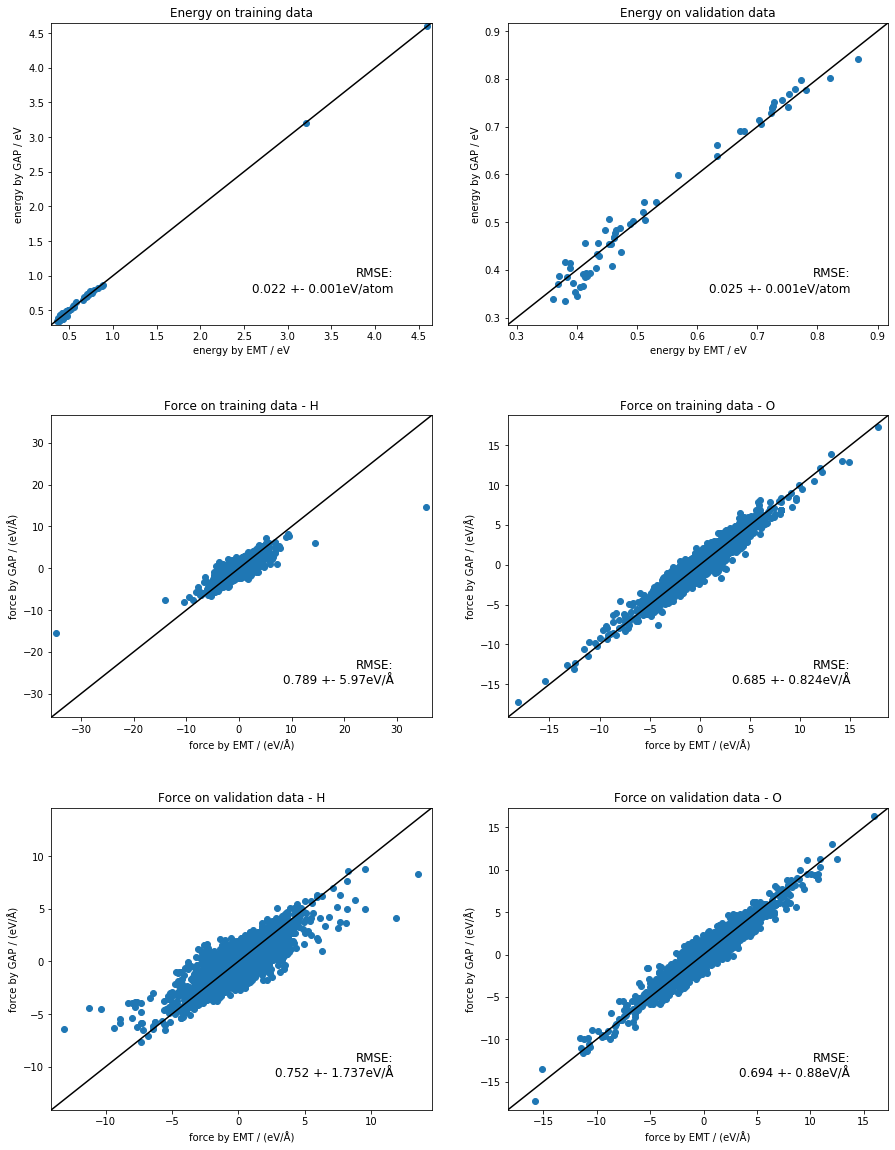

In [11]:
fig, ax_list = plt.subplots(nrows=3, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]

energy_plot('train.xyz', 'quip_3b_train.xyz', ax_list[0], 'Energy on training data')
energy_plot('validate.xyz', 'quip_3b_validate.xyz', ax_list[1], 'Energy on validation data')
force_plot('train.xyz', 'quip_3b_train.xyz', ax_list[2], 'H', 'Force on training data - H')
force_plot('train.xyz', 'quip_3b_train.xyz', ax_list[3], 'O', 'Force on training data - O')
force_plot('validate.xyz', 'quip_3b_validate.xyz', ax_list[4], 'H', 'Force on validation data - H')
force_plot('validate.xyz', 'quip_3b_validate.xyz', ax_list[5], 'O',  'Force on validation data - O')

# if you wanted to have the same limits on the force plots
#for ax in ax_list[2:]:
#    flim = (-20, 20)
#    ax.set_xlim(flim)
#    ax.set_ylim(flim)